# Reliving Avengers: Infinity War with spaCy and Natural Language Processing

### Discovering the top nouns, verbs, entities and text similarity within the spoken lines of Earth’s Mightiest Heroes

After a long year of waiting, **Avengers: Endgame** is finally here. I, like you, and most of the world will be rushing to the cinemas on day one to catch the movie and experience how the Avengers save the world and end a ten years story. To calm down my nerves and ease the wait, I wanted to relive the previous movie, Infinity War, but differently and interactively. And, since I am a data guy, of course, it had to involve data and a couple of buzzwords.

The answer? **Natural Language Processing**, or NLP for short.



Using spaCy, an NLP Python open source library designed to help us process and understand volumes of text, I analyzed the script of the movie to investigate the following concepts:

- Overall top 10 verbs, nouns, adverbs and adjectives from the film.
- Top verbs and nouns spoke by a particular character.
- Top 30 named entities from the film.
- The similarity between the spoken lines of each character pair, e.g., the similarity between Thor’s and Thanos’ lines.

An article that describes the results is found at https://towardsdatascience.com/reliving-avengers-infinity-war-with-spacy-and-natural-language-processing-2abcb48e4ba1

Notebook author: Manuel Romero (https://github.com/mrm8488)

![the mad titan](https://cdn-images-1.medium.com/max/800/1*rjMOOgbiWstWp_XWox-T_A.jpeg)

### Processing the data
The data or text corpus — as is usually known in NLP — used for the experiment is the script of the movie, available at this [link](https://transcripts.fandom.com/wiki/Avengers:_Infinity_War). However, before using the data, I had to clean it up. Thus, I removed some unnecessary things such as the comments that describe an action, or scene e.g. *“[Thanos crushes the Tesseract, revealing the blue Space Stone…]”*, as well as the name of the character who says the line (actually, the name was used to know who said what, but not as part of the actual corpus used for the analysis). Moreover, as part of the spaCy data processing step, I’m ignoring the terms that are labeled as **stop words**, in other words, the commonly used words, e.g. “I”, “you”, “an”. Also, I’m using only the **lemma**, that’s it the canonical form, of each word. For instance, the verbs “talks,” “talked,” and “talking” are forms of the same lexeme, and its lemma is “talk”.

To process a piece of text in spaCy, first, we need to load our language model, followed by calling the model on a text corpus. The result is a ```Doc``` object, an object that holds the processed text.

In [ ]:
!python -m spacy download en_core_web_md

In [1]:
import spacy
import re
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


# load a medium-sized language model
nlp = spacy.load("en_core_web_md")

with open('cleaned-script.txt', 'r') as file:
    text = file.read()
    
doc = nlp(text)

### Top 10 verbs, nouns, adverbs and adjectives

In [2]:
def produce_plot(result, fig_name, kind):
    """Save plot of result
    Parameters:
    result: data to draw
    fig_name: figure name
    kind: type of data used to plot
    """
    
    plt.bar(["\"{}\"".format(i[0]) for i in result], [i[1] for i in result])
    plt.ylabel('total')
    plt.xlabel('term')
    plt.xticks(rotation=45, fontsize=12)
    plt.title("Top {}{} ({})".format(kind, 's', fig_name.title()))
    plt.subplots_adjust(bottom=0.30)
    plt.show()
    plt.close()

In [3]:
def top_pos(doc, pos, n, fig_name=""):
    """Finds the top n spaCy pos

    Parameters:
    doc: spaCy's doc
    pos: pos we are interesting in finding; one of "VERB", "NOUN", "ADJ" or "ADV"
    n: how many pos
    fig_name: name of the plot
    """
    
    pos_count = {}
    for token in doc:
        # ignore stop words
        if token.is_stop:
            continue

        if token.pos_== pos:
            if token.lemma_ in pos_count:
                pos_count[token.lemma_] += 1
            else:
                pos_count[token.lemma_] = 1

    # sort by values, but before get only those keys where value > 1;
    # I want lemmas that appear more than one
    # lastly, get the first n results
    result = sorted({k: v for (k, v) in pos_count.items() if v > 1}.items(),
                    key=lambda kv: kv[1], reverse=True)[:n]

    print("top 10 {} {}".format(pos, result))
    produce_plot(result, fig_name, pos)

top 10 VERB [('know', 59), ('go', 51), ('come', 43), ('get', 40), ('think', 38), ('tell', 27), ('kill', 26), ('need', 24), ('stop', 22), ('want', 22)]


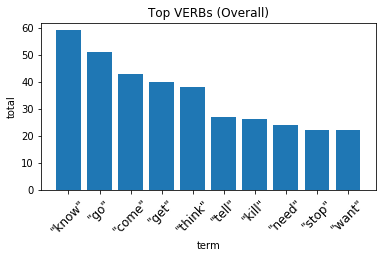

In [4]:
%matplotlib inline
top_pos(doc, 'VERB', 10, "overall")

top 10 NOUN [('stone', 25), ('life', 22), ('time', 21), ('way', 18), ('thing', 16), ('man', 15), ('guy', 13), ('universe', 12), ('ship', 11), ('brother', 9)]


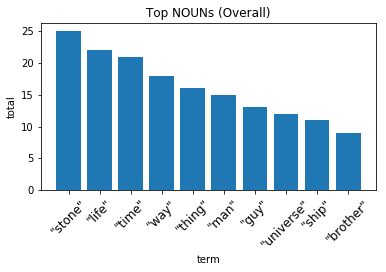

In [5]:
%matplotlib inline
top_pos(doc, 'NOUN', 10, "overall")

top 10 ADJ [('good', 18), ('right', 15), ('sorry', 13), ('little', 11), ('great', 9), ('sure', 8), ('dead', 7), ('big', 7), ('okay', 6), ('wrong', 6)]


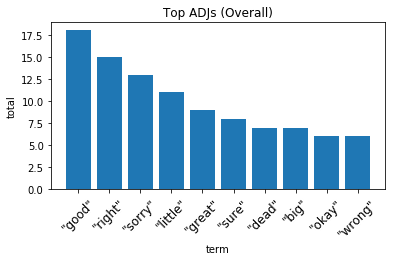

In [6]:
%matplotlib inline
top_pos(doc, 'ADJ', 10, "overall")

top 10 ADV [('right', 15), ('maybe', 9), ('exactly', 8), ('better', 7), ('seriously', 6), ('home', 5), ('long', 5), ('away', 4), ('ago', 4), ('probably', 3)]


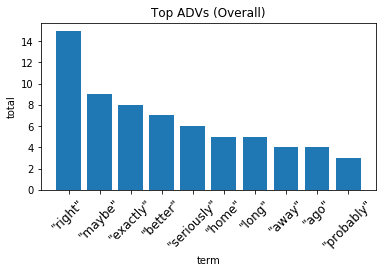

In [7]:
%matplotlib inline
top_pos(doc, 'ADV', 10, "overall")

### Top verbs and nouns mentioned by a particular character

In [8]:
def top_entities(doc, n, fig_name=""):
    """Finds the top n spaCy entities
    Parameters:
    doc: spaCy's doc
    n: how many entities
    fig_name: name of the plot
    """
    
    entities = {}
    # named entities
    for ent in doc.ents:
        # Print the entity text and its label
        if ent.text in entities:
            entities[ent.text] += 1
        else:
            entities[ent.text] = 1
    result = sorted(entities.items(), key=lambda kv: kv[1], reverse=True)[:n]
    print("top 10 entities {}".format(result))

    plt.bar(["\"{}\"".format(i[0]) for i in result], [i[1] for i in result])
    plt.ylabel('total')
    plt.xlabel('named entity')
    plt.xticks(rotation='vertical', fontsize=10)
    plt.title("Top {} named entities ({})".format(n, fig_name.title()))
    plt.subplots_adjust(bottom=0.40)
    plt.show()
    plt.close()

In [9]:
def character_results(nlp):
    """Creates a doc per character using their lines,
    and calculate the top 10 pos and entities
    Parameters:
    nlp: spaCy's nlp
    Returns:
    character:doc dict
   """
    # these are the characters I want to analyze
    subjects = ['thor', 'tony stark', 'bruce banner', 'doctor strange',
                'steve rogers', 'thanos', 'wanda maximoff', 'vision',
                'natasha romanoff', 'gamora', 'peter quill', 'ebony maw',
                'james rhodes', 'rocket', 'peter parker', 'groot', 'drax']
    # create a map of character:doc
    subjects_docs = {}

    for subject in subjects:
        with open('cleaned-script-subject.txt', 'r') as file:
            # this list will contain all the lines produced by the subject
            lines_with_subject = []
            for line in file:
                if line.lower().startswith(subject):
                    # remove the subject, e.g. Thanos :.... before appending
                    lines_with_subject.append(re.sub(r'.*:', '', line.lower()))
        # create a doc using a long string with line break between line
        # made from all the lines spoken by the subject
        doc = nlp('\n'.join(lines_with_subject))
        top_pos(doc, 'VERB', 10, subject)
        top_pos(doc, 'NOUN', 10, subject)
        top_pos(doc, 'ADJ', 10, subject)
        top_pos(doc, 'ADV', 10, subject)
        top_entities(doc, 10, subject)
        subjects_docs[subject] = doc

    return subjects_docs

Subject: thor
top 10 VERB [('know', 7), ('kill', 7), ('go', 6), ('die', 4), ('destroy', 3), ('feel', 3), ('stop', 3), ('tell', 2), ('stab', 2), ('need', 2)]


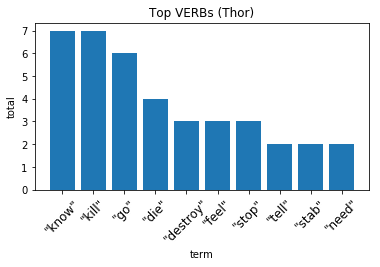

top 10 NOUN [('thanos', 8), ('stone', 7), ('hammer', 4), ('rabbit', 4), ('asgard', 3), ('pod', 3), ('power', 3), ('mind', 3), ('eitri', 3), ('brother', 2)]


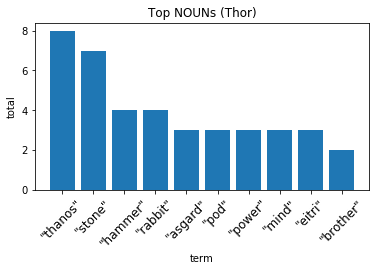

top 10 ADJ [('dark', 3), ('good', 2), ('dead', 2), ('alive', 2), ('late', 2)]


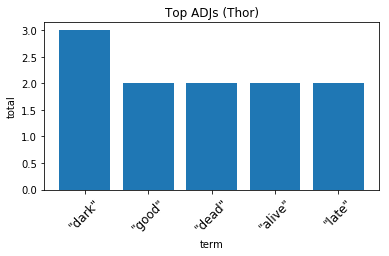

top 10 ADV [('maybe', 2)]


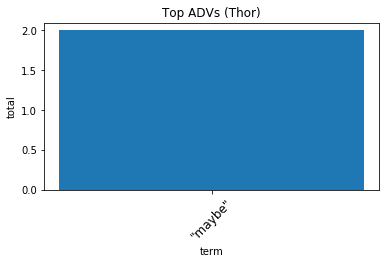

top 10 entities [('half', 2), ('four', 1), ('first', 1), ('years', 1), ('six', 1), ('last week', 1), ('1,500 years old', 1)]


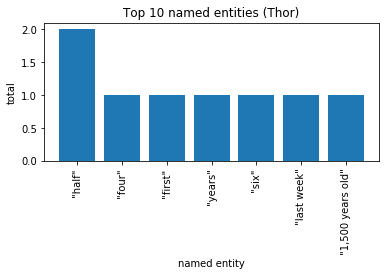

Subject: tony stark
top 10 VERB [('know', 9), ('get', 9), ('go', 6), ('let', 6), ('hear', 6), ('want', 5), ('come', 5), ('think', 5), ('stop', 5), ('wanna', 4)]


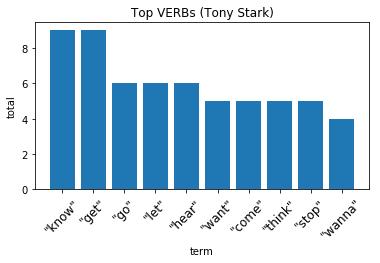

top 10 NOUN [('kid', 7), ('thing', 5), ('earth', 4), ('guy', 4), ('plan', 4), ('quill', 4), ('dream', 3), ('stone', 3), ('doc', 3), ('time', 3)]


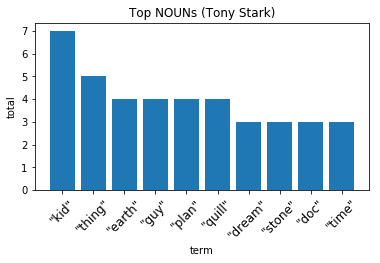

top 10 ADJ [('good', 5), ('sorry', 4), ('right', 3), ('real', 2), ('nice', 2), ('sure', 2), ('alright', 2)]


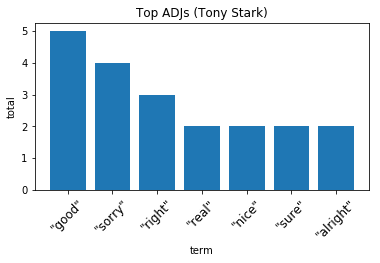

top 10 ADV [('right', 3), ('seriously', 2), ('exactly', 2), ('probably', 2), ('better', 2), ('outta', 2), ('possibly', 2)]


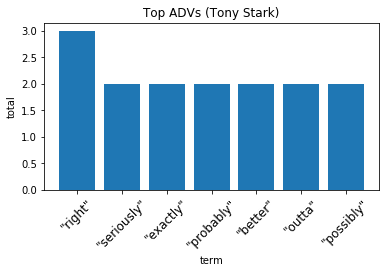

top 10 entities [('one', 3), ('last night', 1), ('tonight', 1), ("ben & jerry's", 1), ('two weeks ago', 1), ('steve', 1), ('wong', 1), ('43rd', 1), ('first', 1), ('today', 1)]


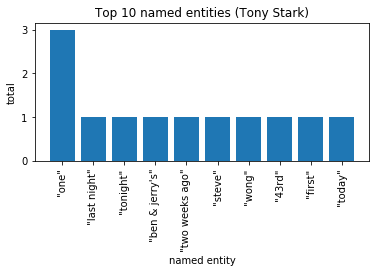

Subject: bruce banner
top 10 VERB [('come', 12), ('get', 6), ('go', 5), ('know', 4), ('think', 4), ('need', 3), ('want', 2), ('make', 2), ('mean', 2), ('look', 2)]


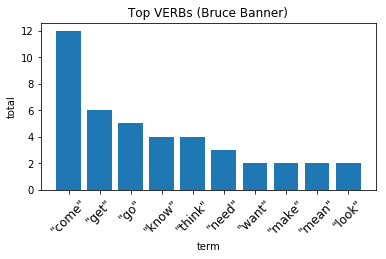

top 10 NOUN [('hulk', 8), ('stone', 7), ('vision', 5), ('thanos', 4), ('tony', 3), ('thing', 3), ('guy', 3), ('man', 3), ('york', 2), ('universe', 2)]


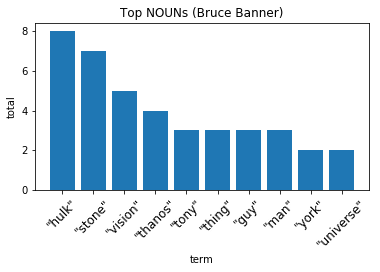

top 10 ADJ [('big', 3), ('new', 2), ('good', 2), ('okay', 2)]


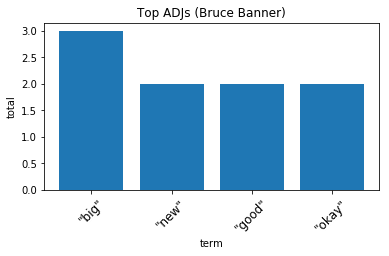

top 10 ADV []


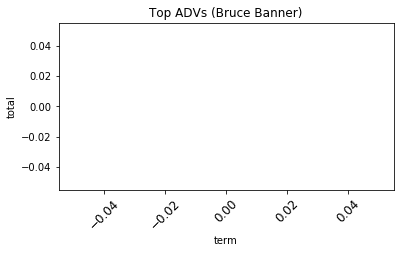

top 10 entities [('york', 2), ('half', 1), ('six', 1), ('one second', 1), ('the last second', 1), ('last second', 1)]


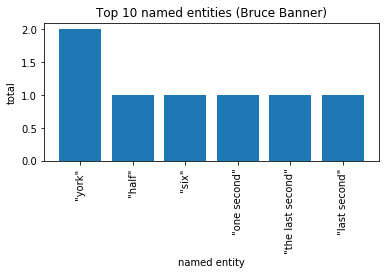

Subject: doctor strange
top 10 VERB [('want', 3), ('come', 3), ('protect', 3), ('find', 3), ('think', 3), ('need', 2), ('bring', 2), ('understand', 2), ('let', 2)]


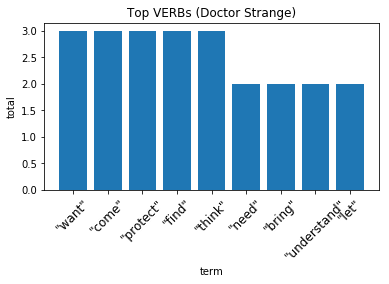

top 10 NOUN [('stone', 6), ('time', 5), ('life', 3), ('thanos', 3), ('doctor', 2), ('congratulation', 2), ('way', 2), ('fate', 2), ('universe', 2), ('stake', 2)]


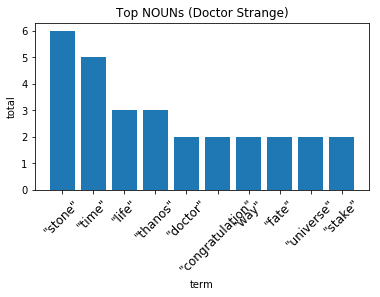

top 10 ADJ [('stark', 3), ('strange', 2)]


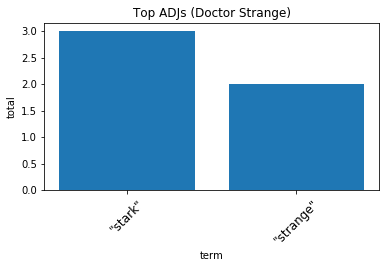

top 10 ADV [('seriously', 3), ('home', 2)]


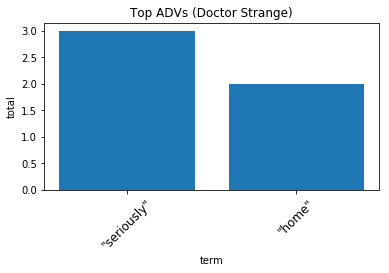

top 10 entities [('14,000,605', 1), ('trillions', 1)]


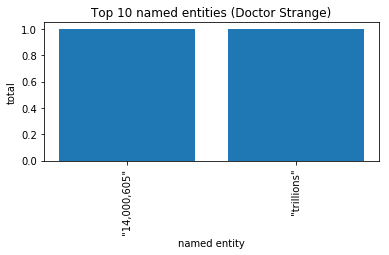

Subject: steve rogers
top 10 VERB [('fight', 2)]


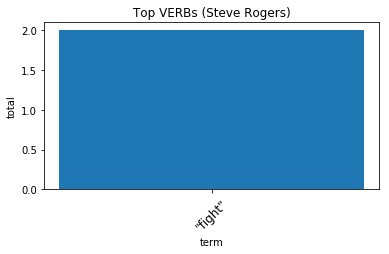

top 10 NOUN [('vision', 2)]


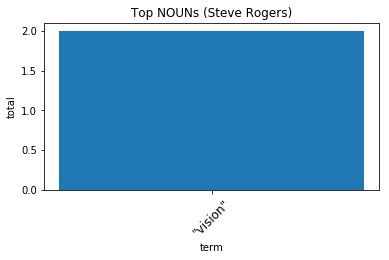

top 10 ADJ []


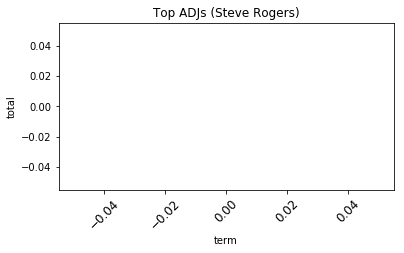

top 10 ADV []


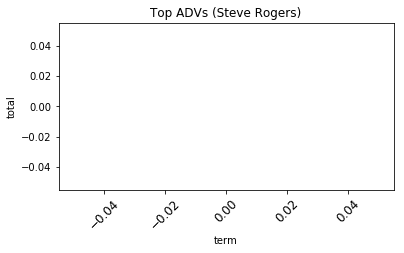

top 10 entities [('2600', 1), ('0-3-0', 1), ('steve', 1)]


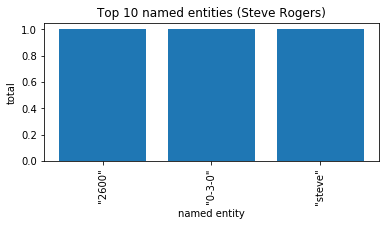

Subject: thanos
top 10 VERB [('know', 11), ('find', 3), ('bring', 3), ('come', 3), ('think', 3), ('need', 3), ('tell', 3), ('lose', 2), ('ask', 2), ('understand', 2)]


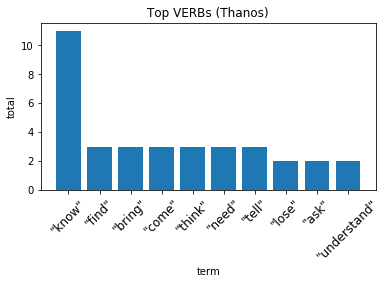

top 10 NOUN [('stone', 8), ('time', 5), ('daughter', 5), ('child', 3), ('reality', 3), ('day', 3), ('soul', 3), ('destiny', 2), ('brother', 2), ('head', 2)]


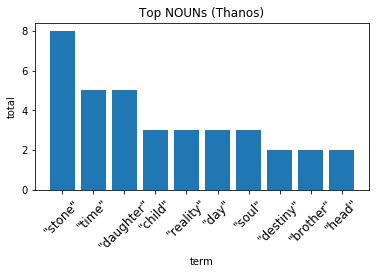

top 10 ADJ [('little', 4), ('great', 2), ('hungry', 2), ('finite', 2), ('strong', 2), ('stark', 2)]


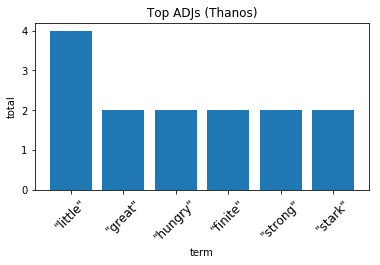

top 10 ADV []


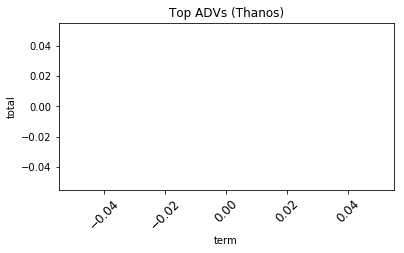

top 10 entities [('two', 1), ('one', 1), ('one day', 1), ('every day', 1), ('almost twenty years', 1), ('this day', 1), ('six', 1), ('half', 1), ('today', 1)]


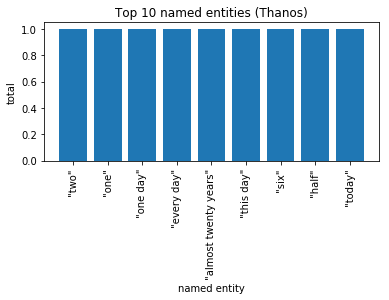

Subject: wanda maximoff
top 10 VERB [('come', 4), ('got', 2), ('stay', 2)]


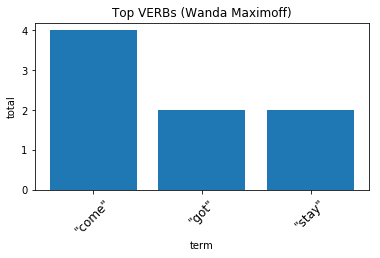

top 10 NOUN [('vision', 4), ('stone', 2)]


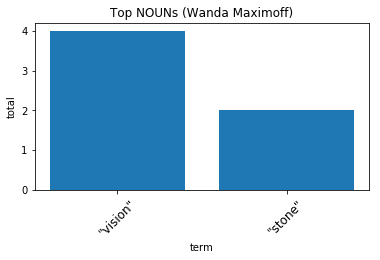

top 10 ADJ []


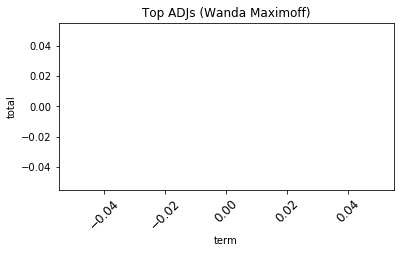

top 10 ADV []


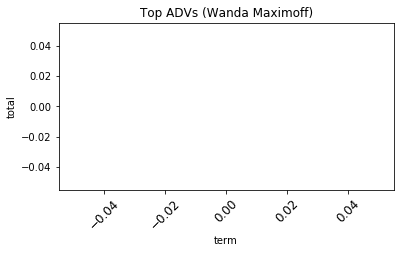

top 10 entities [('11', 1)]


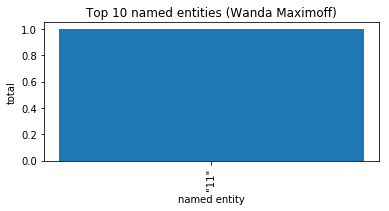

Subject: vision
top 10 VERB [('know', 3), ('think', 3), ('stay', 3), ('destroy', 3), ('speak', 2), ('tell', 2), ('feel', 2), ('miss', 2), ('work', 2), ('stop', 2)]


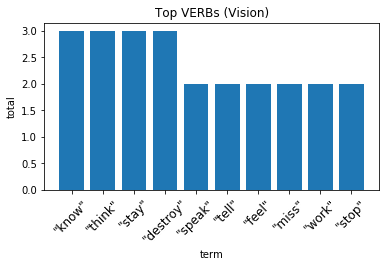

top 10 NOUN [('stone', 5), ('time', 3), ('captain', 3), ('life', 3), ('train', 2), ('year', 2), ('way', 2), ('thanos', 2), ('power', 2), ('universe', 2)]


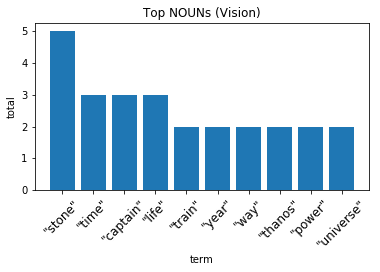

top 10 ADJ [('right', 3)]


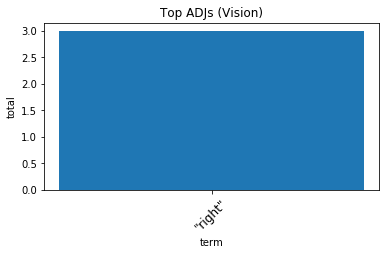

top 10 ADV []


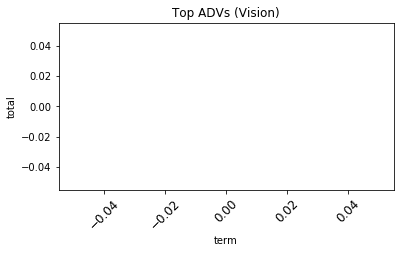

top 10 entities [('half', 2), ('two years', 1), ('70 years ago', 1), ('how many millions', 1)]


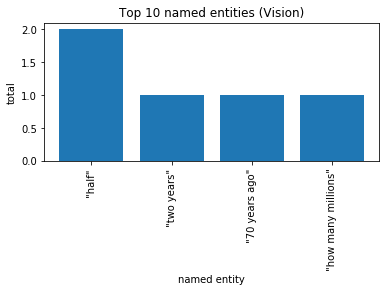

Subject: natasha romanoff
top 10 VERB [('look', 3)]


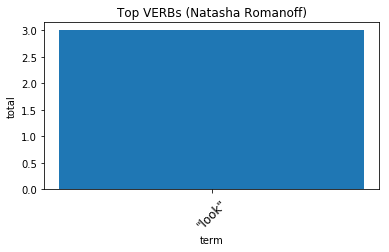

top 10 NOUN [('deal', 2), ('bruce', 2)]


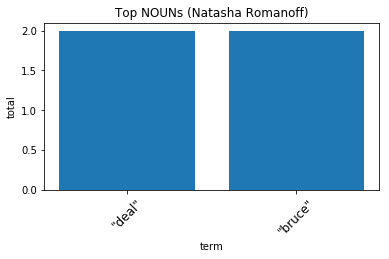

top 10 ADJ []


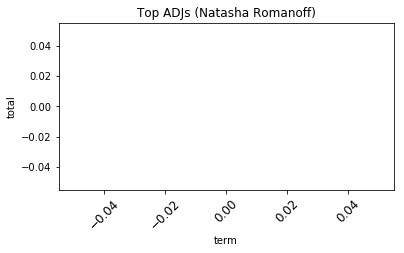

top 10 ADV []


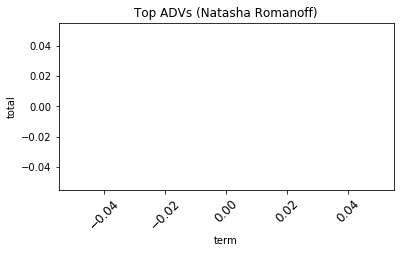

top 10 entities [('scott', 1)]


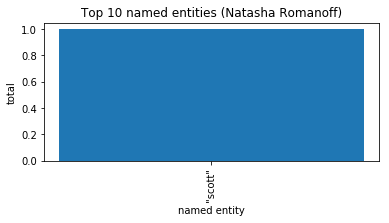

Subject: gamora
top 10 VERB [('know', 6), ('kill', 4), ('stop', 4), ('need', 3), ('find', 3), ('promise', 3), ('swear', 3), ('hat', 3), ('die', 2), ('get', 2)]


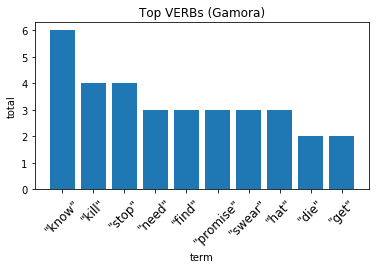

top 10 NOUN [('stone', 5), ('life', 4), ('planet', 4), ('thanos', 4), ('universe', 3), ('massacre', 2)]


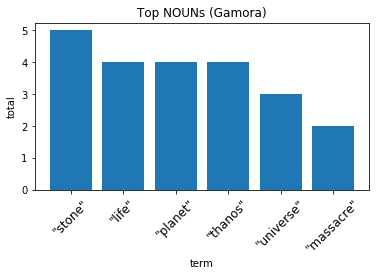

top 10 ADJ [('safe', 2)]


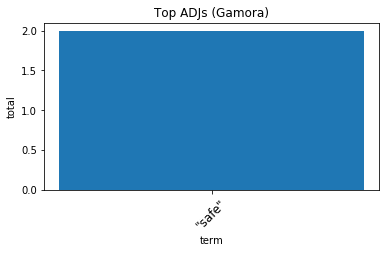

top 10 ADV [('knowhere', 2)]


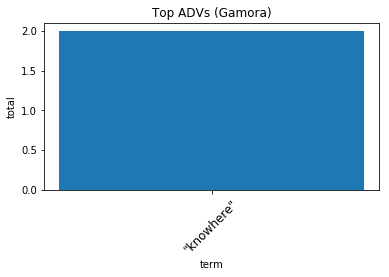

top 10 entities [('half', 2), ('one', 2), ('cotati', 1), ('six', 1)]


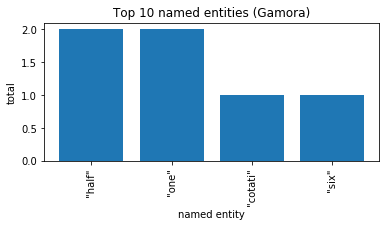

Subject: peter quill
top 10 VERB [('go', 8), ('tell', 7), ('let', 6), ('kill', 6), ('think', 5), ('mean', 4), ('know', 4), ('look', 3), ('like', 3), ('forget', 2)]


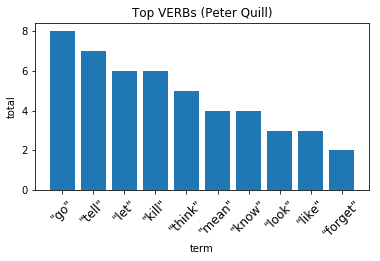

top 10 NOUN [('drax', 7), ('gamora', 5), ('b', 3), ('place', 3), ('stone', 3), ('kind', 3), ('plan', 3), ('face', 2), ('groot', 2), ('dude', 2)]


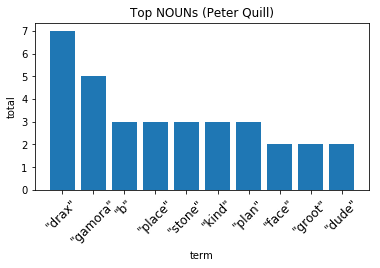

top 10 ADJ [('little', 2), ('hard', 2), ('fine', 2)]


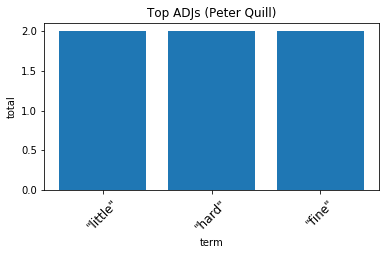

top 10 ADV [('right', 7), ('good', 2)]


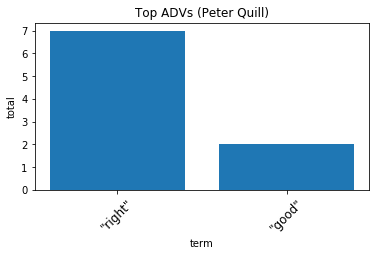

top 10 entities [('today', 1), ('first', 1), ('three', 1), ('missouri', 1), ('eight degrees', 1), ('half', 1), ('50%', 1), ('100%', 1)]


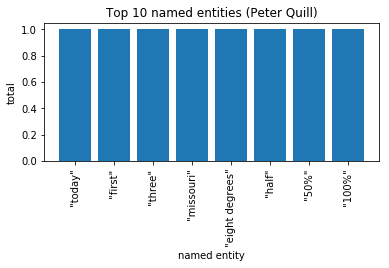

Subject: ebony maw
top 10 VERB [('hear', 2), ('rejoice', 2), ('save', 2), ('die', 2)]


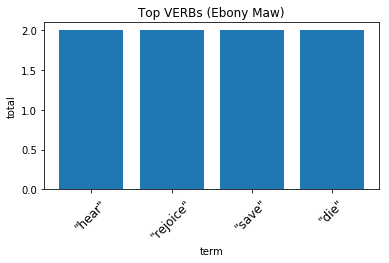

top 10 NOUN [('stone', 4), ('child', 3), ('thanos', 3), ('titan', 2), ('life', 2), ('power', 2), ('time', 2)]


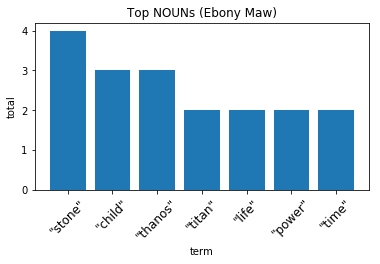

top 10 ADJ []


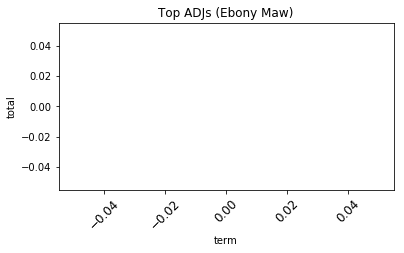

top 10 ADV []


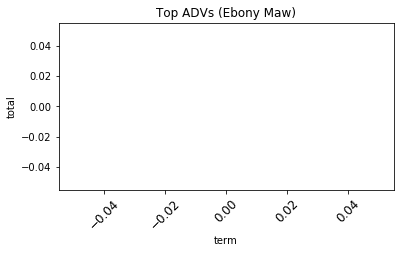

top 10 entities [('two', 1), ('one', 1)]


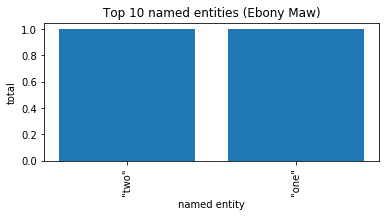

Subject: james rhodes
top 10 VERB [('get', 3), ('go', 2)]


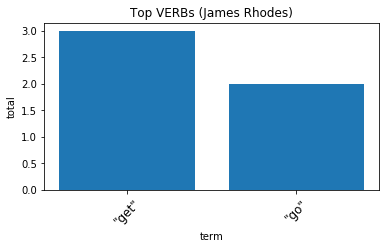

top 10 NOUN [('sam', 4), ('guy', 3)]


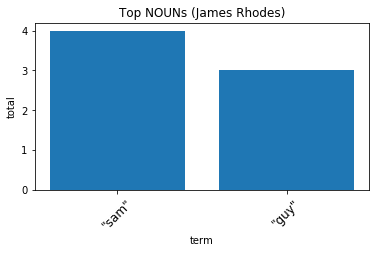

top 10 ADJ [('right', 2)]


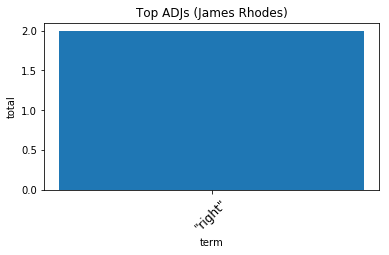

top 10 ADV []


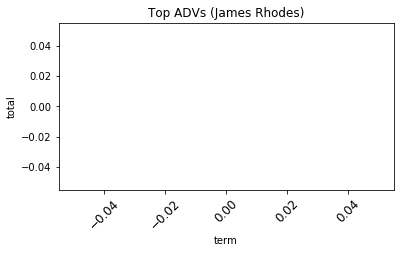

top 10 entities [('couple of years', 1), ('two', 1)]


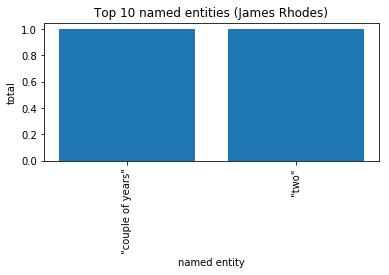

Subject: rocket
top 10 VERB [('get', 6), ('come', 5), ('go', 4), ('look', 4), ('lose', 3), ('know', 2), ('wanna', 2), ('talk', 2), ('say', 2), ('need', 2)]


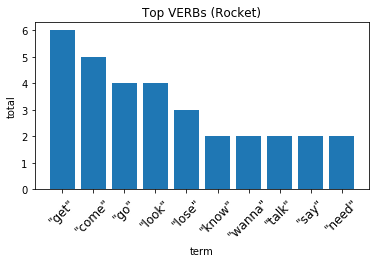

top 10 NOUN [('quill', 3), ('captain', 3), ('thanos', 3), ('lot', 3), ('space', 3), ('wiper', 2), ('moron', 2), ('way', 2), ('groot', 2), ('twig', 2)]


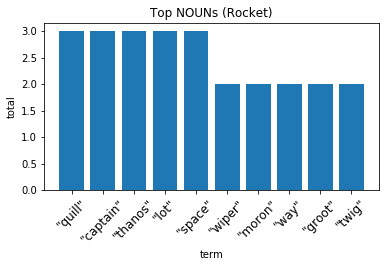

top 10 ADJ [('right', 2), ('cool', 2), ('damn', 2)]


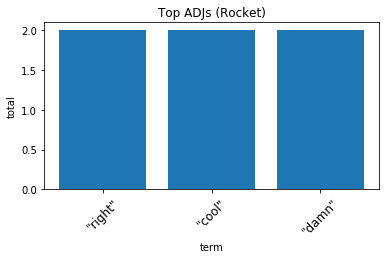

top 10 ADV []


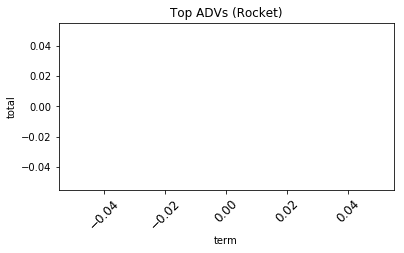

top 10 entities [('two', 2), ('second', 1), ('more than one', 1), ('100', 1), ('later that night', 1)]


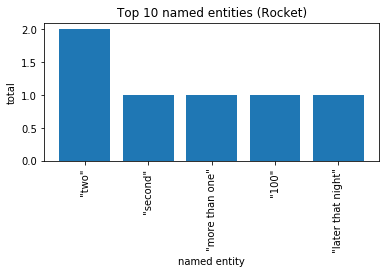

Subject: peter parker
top 10 VERB [('come', 5), ('get', 5), ('wanna', 5), ('know', 4), ('turn', 4), ('save', 3), ('go', 3), ('think', 2), ('try', 2)]


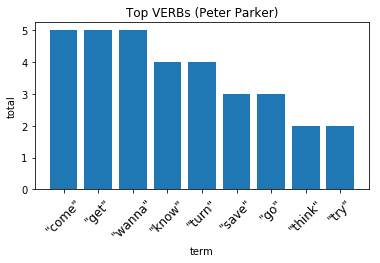

top 10 NOUN [('way', 4), ('magic', 4), ('man', 3), ('sense', 2), ('neighborhood', 2), ('spider', 2), ('movie', 2), ('alien', 2), ('name', 2), ('egg', 2)]


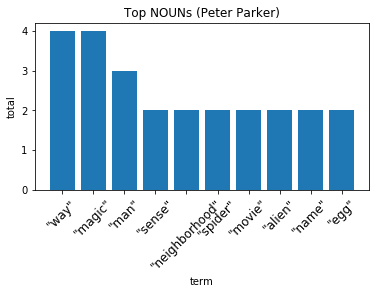

top 10 ADJ [('stark', 5), ('sorry', 3), ('cool', 2)]


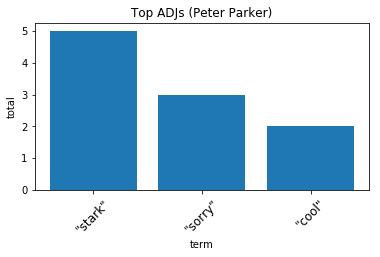

top 10 ADV [('kinda', 2)]


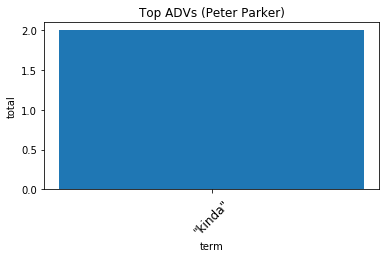

top 10 entities [('peter', 1)]


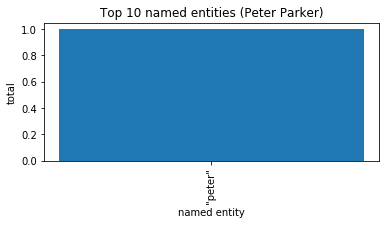

Subject: groot
top 10 VERB []


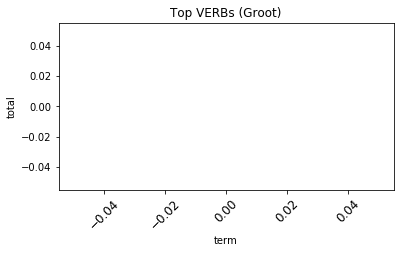

top 10 NOUN [('groot', 7)]


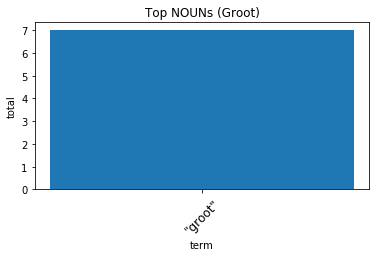

top 10 ADJ []


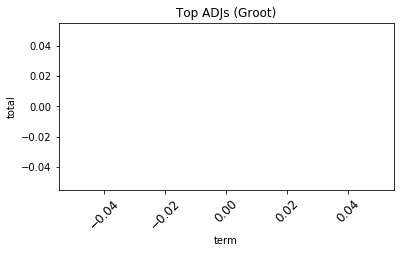

top 10 ADV []


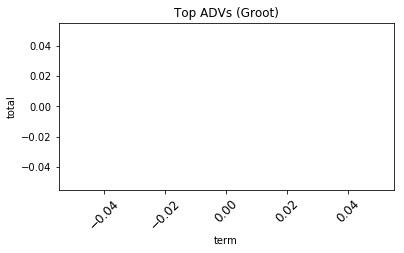

top 10 entities []


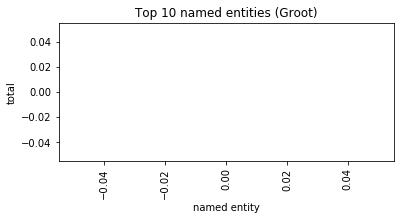

Subject: drax
top 10 VERB []


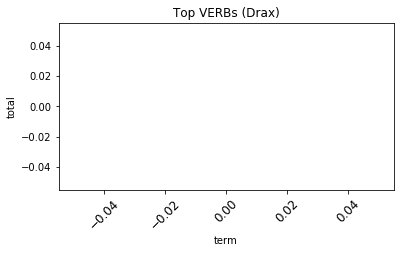

top 10 NOUN [('man', 3), ('dude', 2), ('gamora', 2), ('daughter', 2), ('thanos', 2), ('movement', 2), ('death', 2)]


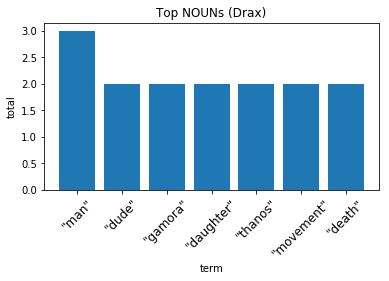

top 10 ADJ [('invisible', 2)]


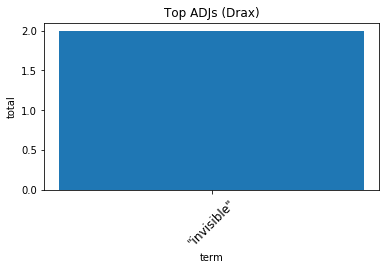

top 10 ADV []


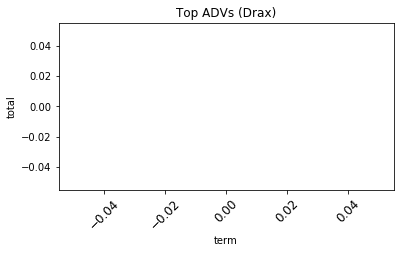

top 10 entities [('third', 1), ('today', 1), ('one', 1)]


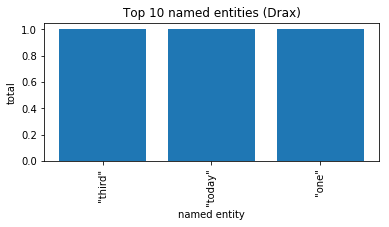

In [10]:
subjects_docs = character_results(nlp)

In [11]:
def docs_similarities(subjects_docs):
    # remove Groot from dict 
    del subjects_docs['groot']
    # create a square ndarray of len(subjects_docs) filled with 1's
    similarities_matrix = np.full((len(subjects_docs), len(subjects_docs)), fill_value=1.0)

    # for every possible combination pair
    # e.g. (Tony, Strange), (Tony, Rocket) and so on
    for a, b in itertools.product(enumerate(subjects_docs), repeat=2):
        similarity_score = subjects_docs[a[1]].similarity(subjects_docs[b[1]])
        print("Similarity between {} and {} docs is {}".format(a[1], b[1], similarity_score))
        similarities_matrix[a[0], b[0]] = similarity_score

    plt.matshow(similarities_matrix, interpolation='nearest')
    plt.yticks(range(len(subjects_docs)), subjects_docs.keys())
    plt.xticks(range(len(subjects_docs)), subjects_docs.keys(), rotation='vertical')
    plt.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
    plt.colorbar()
    plt.title("Character's Corpus Similarity Matrix")
    plt.show()
    plt.close()

### The similarity between the spoken lines of each character pair

Similarity between thor and thor docs is 1.0
Similarity between thor and tony stark docs is 0.9937895513726398
Similarity between thor and bruce banner docs is 0.994496165465929
Similarity between thor and doctor strange docs is 0.9934792136595321
Similarity between thor and steve rogers docs is 0.9873623490477792
Similarity between thor and thanos docs is 0.9965986336725233
Similarity between thor and wanda maximoff docs is 0.9873662601150033
Similarity between thor and vision docs is 0.9937780933223939
Similarity between thor and natasha romanoff docs is 0.9909575213080908
Similarity between thor and gamora docs is 0.9940187522680113
Similarity between thor and peter quill docs is 0.9926865540973882
Similarity between thor and ebony maw docs is 0.9873578555414395
Similarity between thor and james rhodes docs is 0.9916402666134809
Similarity between thor and rocket docs is 0.9919330372931638
Similarity between thor and peter parker docs is 0.9784141210885672
Similarity between thor an

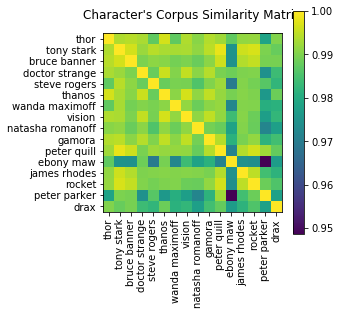

In [12]:
docs_similarities(subjects_docs)